In [12]:
from helpers.dataset import CreateTensorflowDataset
# https://stackoverflow.com/questions/66805180/how-to-get-iou-of-single-class-in-keras-semantic-segmentation
# Creates the dataset not upscaled
data_path = '/workspaces/Satelite/data'
upscaled = False
list_of_cantons = ['AG', 'AI', 'BE', 'BL', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VS', 'ZG', 'ZH']
loader = CreateTensorflowDataset(data_path, list_of_cantons, upscaled)

Preparing the dataset...


2024-05-20 14:49:32.251165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2981]
	 [[{{node Placeholder/_1}}]]
2024-05-20 14:50:19.639170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [372]
	 [[{{node Placeholder/_1}}]]
2024-05-20 14:50:25.590821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [374]


Done preparing the dataset.


In [15]:
from helpers.dataset import CreateTensorflowDataset

# Creates the dataset upscaled
data_path = '/workspaces/Satelite/data'
upscaled = True
list_of_cantons = ['AG', 'AI', 'BE', 'BL', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VS', 'ZG', 'ZH']
loader = CreateTensorflowDataset(data_path, list_of_cantons, upscaled)

Preparing the dataset...


2024-05-20 15:02:35.798405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [3020]
	 [[{{node Placeholder/_1}}]]
2024-05-20 15:04:08.310805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [377]
	 [[{{node Placeholder/_1}}]]
2024-05-20 15:04:20.283784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [378]


Done preparing the dataset.


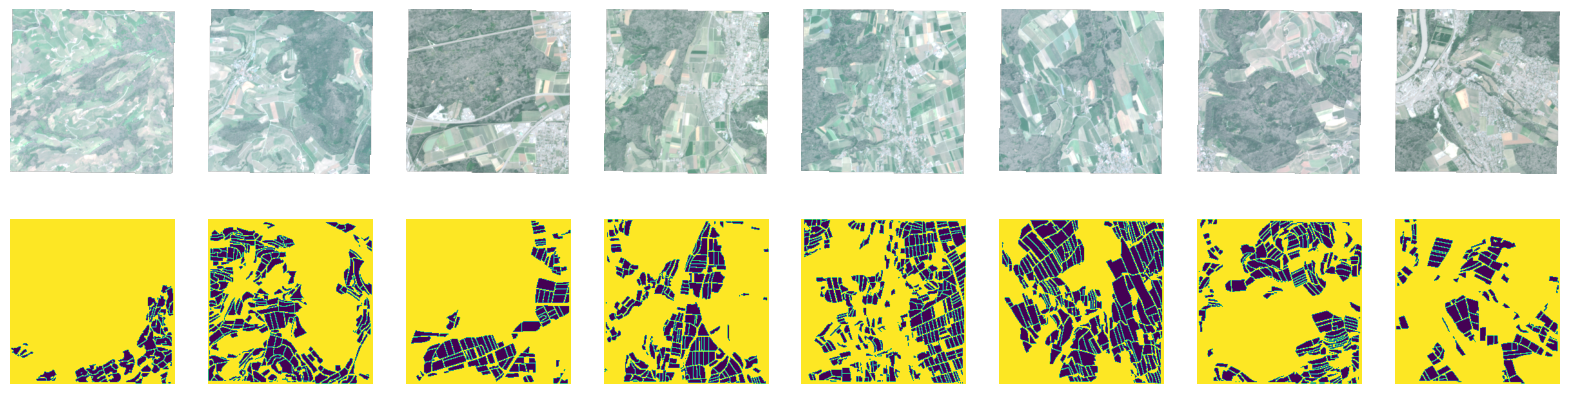

In [7]:
# Plot the images and masks
def plot_images(images, masks, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[0, i].imshow(images[i])
        ax[0, i].axis('off')
        ax[1, i].imshow(masks[i])
        ax[1, i].axis('off')
    plt.show()
    
# Load the images and masks
for images, masks in val_data.dataset.take(1):
    plot_images(images, masks)
    
# Load the images and masks


In [30]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from helpers.UNET import UNET
from helpers.load import LoadandAugment

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders
train_data = LoadandAugment(train_path, "train", 32, False)
val_data = LoadandAugment(val_path, "val", 32, False)

# Define the Dice loss
def dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice

# Define the Jaccard distance loss
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

# Define the Dice metric
def dice_metric(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

# Initialize UNET model
unet = UNET(input_shape=(256, 256, 4))
unet.model.compile(optimizer='adam', loss=jaccard_distance_loss, metrics=[dice_metric])

# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
unet.model.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=40, 
    callbacks=[checkpoint_callback]
)

Epoch 1/2
93/94 [============================>.] - ETA: 0s - loss: 0.3101 - dice_metric: 0.8450
Epoch 1: val_loss improved from inf to 0.48282, saving model to best_model.h5
94/94 [==============================] - 34s 287ms/step - loss: 0.3100 - dice_metric: 0.8450 - val_loss: 0.4828 - val_dice_metric: 0.7597
Epoch 2/2
93/94 [============================>.] - ETA: 0s - loss: 0.2797 - dice_metric: 0.8586
Epoch 2: val_loss did not improve from 0.48282
94/94 [==============================] - 25s 268ms/step - loss: 0.2795 - dice_metric: 0.8586 - val_loss: 0.4945 - val_dice_metric: 0.7528


1/1 [==============================] - 0s 209ms/step
Min prediction value: 0.0
Max prediction value: 1.0


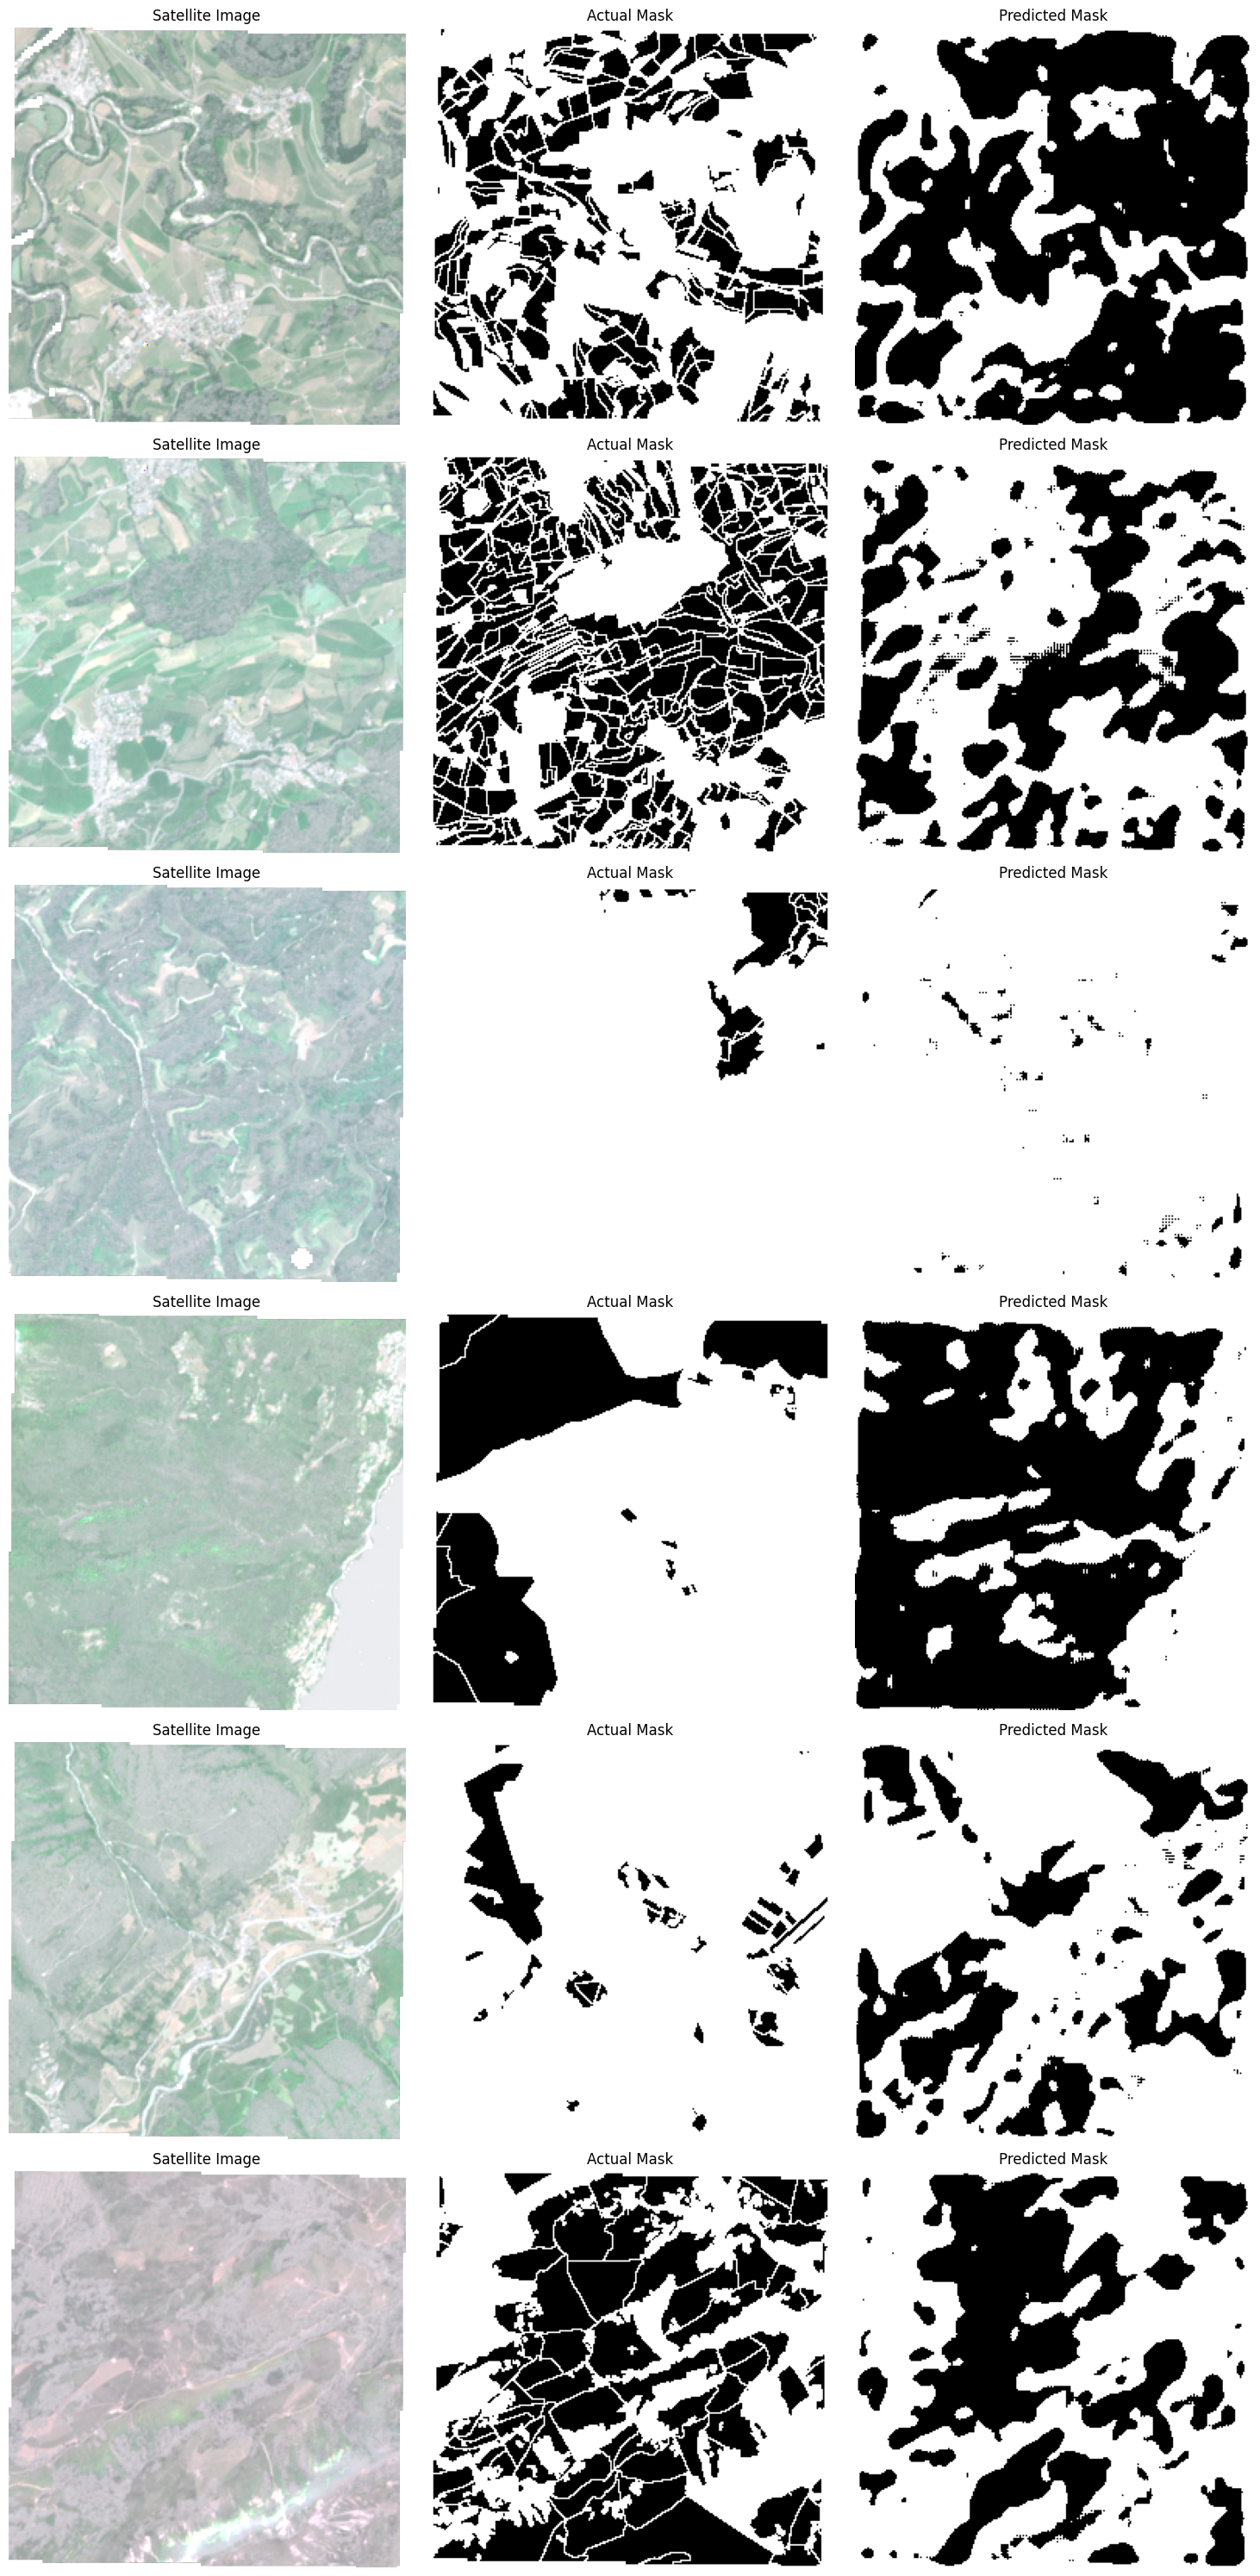

In [31]:

import numpy as np
from helpers.UNET import UNET
import matplotlib.pyplot as plt
from helpers.load import LoadandAugment
import os 

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
test_path = os.path.join(path, "test")

def plot_predictions(images, masks, predictions, num=6):
    plt.figure(figsize=(15, 5*num))
    
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Satellite Image")
        plt.axis('off')
        
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num, 3, i*3+3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the best model
unet.model.load_weights('best_model.h5')

# Evaluate the model
test_data = LoadandAugment(test_path, "test", 10, True)

# Predict on the test data
for images, masks in test_data.dataset:
    break
predictions = unet.model.predict(images)
predictions = (predictions > 0.5).astype(np.float32) 

# Check predictions
print("Min prediction value:", predictions.min())
print("Max prediction value:", predictions.max())

# Plot the predictions
plot_predictions(images.numpy(), masks, predictions)
